In [1]:
%load_ext autoreload
%autoreload 2

In [7]:
import numpy as np
from datasets import load_dataset
from tqdm import tqdm
from utils.edit_distance import compute_ngram_distance_damerau_levenshtein
from utils.LCS import find_longest_common_substrings

In [18]:
# file_path = '/mloscratch/homes/yixuan/PDM/inference/llama_1.5B_Goldfish_K_21_H_13_GBS_120_EPOCH_79/step=600-consumed=72000_rank0.jsonl'
file_path = '/mloscratch/homes/yixuan/PDM/inference/llama_1.5B_Goldfish_K_21_H_13_GBS_120_EPOCH_79/step=5925-consumed=711000_rank0.jsonl'
data = load_dataset('json', data_files=file_path, split='train')

In [ ]:
def describe_array(arr):
    """
    Get descriptive statistics for a numpy array.
    Similar to pandas describe() but for numpy arrays.
    
    Parameters
    ----------
    arr : np.ndarray
        Input array
        
    Returns
    -------
    dict
        Dictionary containing statistics
    """
    stats = {
        'count': len(arr),
        'mean': np.mean(arr),
        'std': np.std(arr),
        'min': np.min(arr),
        '25%': np.percentile(arr, 25),
        '50%': np.median(arr),
        '75%': np.percentile(arr, 75),
        'max': np.max(arr)
    }
    
    # Print in a format similar to pandas describe()
    print("Statistical Description:")
    print(f"count    {stats['count']}")
    print(f"mean     {stats['mean']:.2f}")
    print(f"std      {stats['std']:.2f}")
    print(f"min      {stats['min']}")
    print(f"25%      {stats['25%']:.2f}")
    print(f"50%      {stats['50%']:.2f}")
    print(f"75%      {stats['75%']:.2f}")
    print(f"max      {stats['max']}")

In [19]:
distances, normalized = compute_ngram_distance_damerau_levenshtein(data, N=13)

Converting data to numpy arrays...
Creating sliding windows...
Input shapes: ref_ngrams=(10000, 488, 13), pred_ngrams=(10000, 488, 13)
Warming up Numba JIT...
Computing distances...
Time taken: 0.50 seconds
Output shapes: distances=(10000, 488), normalized=(10000, 488)


In [53]:
distances.shape

(10000, 488)

In [63]:
row_means = distances.mean(axis=1)
describe_array(distances[:9000].mean(axis=1))

Statistical Description:
count    9000
mean     12.10
std      0.90
min      0.05327868852459016
25%      11.83
50%      12.39
75%      12.70
max      12.993852459016393


In [65]:
k = 5
top_k_indices = np.argsort(row_means)[:k]

In [66]:
top_k_indices

array([8413,  546, 8412, 5460, 3078])

Converting data to numpy arrays...
Creating sliding windows...
Input shapes: ref_ngrams=(10000, 496, 5), pred_ngrams=(10000, 496, 5)
Warming up Numba JIT...
Computing distances...
Time taken: 0.32 seconds
Output shapes: distances=(10000, 496), normalized=(10000, 496)


<Axes: >

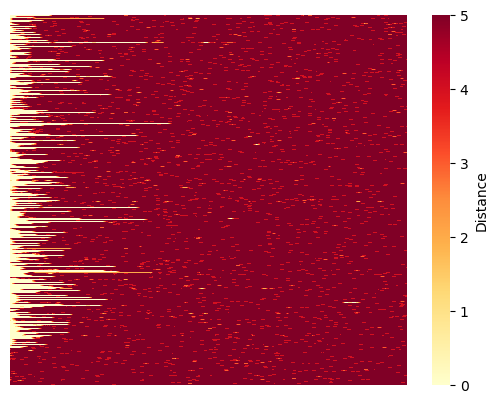

In [69]:
distances, normalized = compute_ngram_distance_damerau_levenshtein(data, N=5)
sns.heatmap(
    distances[:10000], 
    cmap='YlOrRd',  # Use a colormap good for distances
    xticklabels=False,  # Don't show x ticks for large matrices
    yticklabels=False,  # Don't show y ticks for large matrices
    cbar_kws={'label': 'Distance'})

In [21]:
res_statistics = find_longest_common_substrings(data['true_suffix'], data['generated_suffix'])

Warming up Numba JIT...
Processing 10000 sequence pairs in parallel...
Time taken: 1.31 seconds


In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
res_statistics.filter(items=['length']).hist(bins=100)

,max_length,start_pos1,end_pos1,start_pos2,end_pos2
0,16,0,16,0,16
1,6,0,6,0,6
2,22,0,22,0,22
3,4,0,4,0,4
4,3,459,462,175,178
...,...,...,...,...,...
9995,4,235,239,177,181
9996,3,85,88,413,416
9997,5,157,162,129,134
9998,3,14,17,133,136


<Axes: xlabel='max_length', ylabel='Count'>

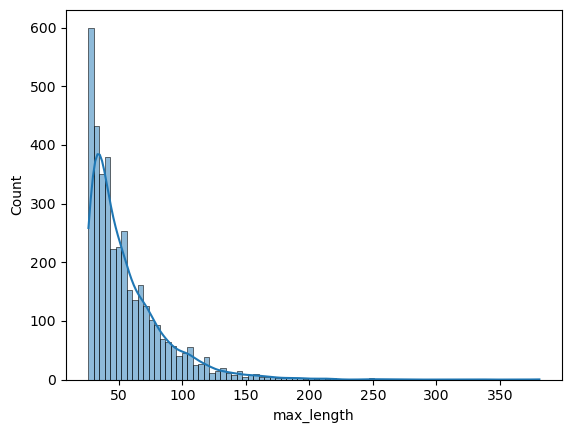

In [52]:
sns.histplot(
    data=res_statistics[res_statistics['max_length'] > 25],
    x='max_length', 
    kde=True, 
    # log_scale=(True, True)
)